In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import itertools
import time
from collections import Counter
import hdbscan
## get that here: https://github.com/scikit-learn-contrib/hdbscan

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
pd.options.display.max_columns=300
pd.options.display.max_rows=100
# from TurbineTimeSeries.storage import MachineDataStore
plt.rcParams["figure.figsize"] = (14,8)
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin
# %matplotlib inline

In [4]:
# from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN
# from sklearn.mixture import GaussianMixture
# ## for agglomerative clustering, give linkage : {“ward”, “complete”, “average”}

# n_clusts = 3
# kmeans = KMeans(init='k-means++', n_clusters=n_clusts, n_init=10)
# AffinityProp = AffinityPropagation()
# Meanshift = MeanShift(n_jobs=7)
# Spectral = SpectralClustering(n_clusters=n_clusts, affinity='nearest_neighbors',n_jobs=7)
# Agglom_ward = AgglomerativeClustering(n_clusters=n_clusts, linkage='ward')
# Agglom_complete = AgglomerativeClustering(n_clusters=n_clusts, linkage='complete')
# Agglom_avg = AgglomerativeClustering(n_clusters=n_clusts, linkage='average')
# Dbscan = DBSCAN(eps=5, min_samples=n_clusts)
# GMM_spherical = GaussianMixture(n_components=n_clusts, covariance_type='spherical' )
# GMM_diag = GaussianMixture(n_components=n_clusts, covariance_type='diag' )
# GMM_tied = GaussianMixture(n_components=n_clusts, covariance_type='tied' )
# GMM_full = GaussianMixture(n_components=n_clusts, covariance_type='full' )



# clustering_algo_dict = {
#                         'kmeans':kmeans, 
# #                         'AffinityProp': AffinityProp, #mem errors out. affinity propogation calculates full distance matrix so it's quadratic memory required. 10k samples would use ~80gb ram.
#                         'Meanshift':Meanshift,  #runs forever
#                         'Spectral':Spectral, ## runs forever
# #                         'Agglom_ward':Agglom_ward, ## uses too much ram
# #                         'Agglom_complete':Agglom_complete,
# #                         'Agglom_avg':Agglom_avg,
#                        'Dbscan':Dbscan,
#                         'GMM_spherical':GMM_spherical,
#                         'GMM_diag':GMM_diag, 
#                         'GMM_tied':GMM_tied,
#                         'GMM_full':GMM_full
#                        }

## Read in the data

In [5]:
model2_10min = pd.read_csv('../../../data/raw_data_model2_10min.csv')
## convert all to timestamps
model2_10min['timestamp'] = model2_10min['timestamp'].apply(lambda x: pd.Timestamp(x))
model2_10min=model2_10min.sort_values(by=['psn','timestamp'],ascending=(True,True))
model2_10min=model2_10min.dropna()
print('Shape of model2 10min data: ', model2_10min.shape)

Shape of model2 10min data:  (1602281, 76)


### Read in the data dictionary and split features by subsystem

In [7]:
data_dictionary = pd.read_csv('data_dictionary_model2.csv')
subsystem_dict = {str(i).lower(): list(data_dictionary[data_dictionary['SUBSYSTEM']==i]['COLUMN_NAME'].str.lower().values) for i in data_dictionary['SUBSYSTEM'].unique()}
del subsystem_dict['summary'] ## this group pretty useless
print(list(subsystem_dict.keys()))

['gas path', 'fuel', 'generator', 'vibration', 'lube oil system', 'enclosure', 'package equipment']


In [8]:
for i in subsystem_dict.keys():
    print(i,len(subsystem_dict[i]))

gas path 29
fuel 12
generator 12
vibration 6
lube oil system 8
enclosure 2
package equipment 1


In [9]:
def subsystem_pca(df,subsystem_dict,subsystems = [], psns = 'all'):
    
    subset = []
    if isinstance(subsystems,list)==True:
        if len(subsystems) > 0:
            for i in subsystems:
                subset = subset + subsystem_dict[i] ## populate subset with list of columns
        else:
            print('Empty list of subsystems detected. Using all subsystems for PCA')
            subset = [s for L in subsystem_dict.keys() for s in subsystem_dict[L]]
    else: 
        raise Exception('Please ensure subsystems parameter is a list')
        
    if psns == 'all' or isinstance(psns, (list, int))==True:
        pass
    else:
        raise Exception('Please provide a list of psns, single psn, or "all"')
    


    available_subset = [i for i in subset if i in df.columns.values]
    if len(available_subset)<len(subset):
        print('excluding columns: ', list(set(subset)-set(available_subset)))
    available_subset =  available_subset + ['id','timestamp','psn']
    model_data = df[available_subset]
    
    
    
    skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
    index_cols = ['id','timestamp','psn']
    data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]
    
    missing_values = model_data.isnull().sum().sort_values()
    sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
    clean_data_cols = [x for x in data_cols if x not in sparse_cols]
    data = model_data[index_cols + clean_data_cols].dropna()#.reset_index()
    print(data.shape)
    clean_data = StandardScaler().fit_transform(data[clean_data_cols])

    pca =  PCA().fit(clean_data)
    reduced = pca.transform(clean_data)
    reduced_df = pd.DataFrame(reduced)
    reduced_df['psn'] = data.psn.values
    reduced_df['timestamp'] = data.timestamp.values
    return(reduced_df)

In [10]:
def plot_eigs_subplots(reduced_df, n_eigs_x, n_eigs_y, psns, savefig = False,path=None,figname = None):
    if isinstance(n_eigs_x,int) == True:
        pass
    else:
        raise Exception('n_eigs_x must be an integer')
        
    if isinstance(n_eigs_y,int) == True:
        pass
    else:
        raise Exception('n_eigs_y must be an integer')
    

    
    if psns == 'all':
#         fig_base_title = 'All psns'
        pass
    elif isinstance(psns, list)==True:
        model2_10min[model2_10min['psn'].isin(psns)]
#         fig_base_title = 'PSN ' + str(psns)
        
    elif isinstance(psns,int) == True:
        reduced_df = reduced_df[reduced_df['psn']==psns]
#         fig_base_title = 'PSN ' + str(psns)
    else:
        raise Exception('Please provide a list of psns, single psn, or "all"')
        
    if path == None:
        path = ''
    else:
        pass

        
    f, axarr = plt.subplots(n_eigs_x, n_eigs_y)
    f.set_figheight(40)
    f.set_figwidth(40)
    f.suptitle(path + fname,fontsize=16)
    for i in range(n_eigs_x):
        for j in range(n_eigs_y):

            if i==j:
                continue
            axarr[i, j].scatter(reduced_df[i].values,reduced_df[j].values,3,alpha=0.5)
            axarr[i, j].set_title('Eig '+str(i) + ' vs Eig '+ str(j))
    if savefig == False:
        plt.show()
    else:
        
        f.savefig(path+str('\\') + fname +'.png')      
#         f.suptitle(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots',fontsize=16)
#         f.savefig(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots.png')
#         plt.show()
        plt.close()

### Use all features for pca.

Code can support doing pca separately by subsystem but we determined it works better with all at once

In [12]:
rd_df = subsystem_pca(model2_10min,subsystem_dict, [], psns = 'all')
print(rd_df.shape)
## dataframe from pca retains same dimensions as original. we take advantage of this to map back the 'id' column
rd_df['id'] = model2_10min['id']

Empty list of subsystems detected. Using all subsystems for PCA
excluding columns:  ['lo_c_brg1']
(1602281, 72)
(1602281, 71)


In [13]:
def hdbscan_eig_clusterer(reduced_df, cols, cluster_algo, cluster_params, psn='all'):
    """
    reduced_df: dataframe output from a PCA
    doesn't matter what index comes in, that's what will go out anyways
    
    """
    returndf = pd.DataFrame()
    psns = []
    if psn == 'all':
        psns = sorted(reduced_df['psn'].unique())
    else:
        psns = psn
    
    for pkg in psns:
        tempdf = reduced_df[reduced['psn']==pkg]
        min_clust_size = int(len(newdf)/70.3)+1
        clusterer = cluster_algo(min_cluster_size=min_clust_size)
        clusterer = clusterer.fit(tempdf[cols])
        results = clusterer.predict(tempdf[cols])
        tempdf['cluster'] = results
        returndf = returndf.append(tempdf)
    return(reduced_df)

def plot_clusters(cluster_df, x, y, colorpal, save_fig = False, directory=None, title=''):
    plt.figure(figsize=(28,16))
    for i in sorted(cluster_df['cluster'].unique()):
        tempdf = cluster_df[cluster_df['cluster']==i]
        plt.scatter(tempdf[x].values,tempdf[y].values,s=3,alpha=0.5,c=color_pal[i],label = 'cluster '+str(i))
    plt.xlabel('Eigenvector '+str(x))
    plt.ylabel('Eigenvector '+str(y))
    fulltitle = 'Eig '+str(x) + ' vs Eig ' + str(y)+' '+ str(title)#' Clustering using HDBSCAN 20eigs')
    plt.title(title)
    plt.legend()
    if save_fig == True:
        if directory != None:
            plt.savefig(directory + title + 'png')
        else:
            plt.savefig(title+'.png')
        plt.show()
        plt.close()
    else:
        plt.show()


## Cluster exploration on a subset of packages

loop through psns, cluster datapoints, save to file

In [28]:
## Create a simple color pallette for figures. code below will break if it tries to color code more clusters than available colors. in that case, just add more colors to this color pallette list
color_pal = ['#33a02c', '#1f78b4', '#ff7f00', '#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#cab2d6','#6a3d9a']

In [ ]:
num_eigs_toclust = 20 ## 20 eigenvectors cover 90% variance

## create folder to save plots to
current_directory = os.getcwd()
final_directory = os.path.join(current_directory,r'Hdbscan Clustering mc lendiv70')
if not os.path.isdir(final_directory):
    os.mkdir(final_directory)

    
for psn in [35,37,40,45,46,47,49,55,57,58,62]:
    print('started: ',psn)
    nao = time.time()
    
    ## subset dataframe
    newdf = rd_df[rd_df['psn']==psn]
    min_clust_size = int(len(newdf)/70.3)+1 ## arbitrarily choose this value for now
    print('    clustering with min_cluster_size={} min_samples={}.....'.format(min_clust_size,int(min_clust_size)),end="",flush=True)
    
    ## cluster the datapoints
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_clust_size, min_samples=int(min_clust_size))
    clusterer_results = clusterer.fit_predict(newdf[list(range(num_eigs_toclust))])
    print(newdf.shape, len(clusterer_results))
    print('finished in {} seconds'.format(time.time()-nao))
    newdf['cluster'] = clusterer_results
    
    ## create and save plot
    figname = 'PSN '+str(psn)+'HDBSCAN Clustering 20eigs minsize='+str(min_clust_size)
    print('    saving figure.....',end="",flush=True)
    plot_clusters(newdf, x=0, y=1, colorpal = color_pal, save_fig=True, directory=final_directory+'\\', title = figname)
    print('finished in total {} seconds'.format(time.time()-nao))


### validate different cluster parameters using powerstep function 

In [42]:
def find_power_step (df,powercol,jump = 0.2):
    ## function will return another dataframe where the power columns is replace with 1s and 0s. 1 represents an outlier.
    ## jumps is a percentage
    ## assumes data coming in is sorted by psn by timestamp.

    
    df = df[[powercol,'timestamp','psn']]

    df = df.where((pd.notnull(df)),np.nan) ## replaces nulls with nans for math stuffs.
    df2 = pd.DataFrame(index = df.index.values[1:],columns = df.columns.values)
    df2['timestamp'] = df['timestamp'].values[1:]
    ## np.divide will divide the first parameter by the second parameter so the resulting series starts
    ## from the original dataframe's 1st item, not the 0th item.
#     shifted = pd.Series(np.subtract(df[powercol].values[1:],df[powercol].values[:-1]),index=df.index.values[:-1])

    shifted = pd.Series(np.divide(df[powercol].values[:-1],df[powercol].values[1:]),index=df.index.values[1:])-1

    ## take all values and subtract from previous values. if unchanging, then result will be 0
    ## create numpy array of all False

    tomap = np.zeros(len(df2),dtype=int)  
    
    
    ## find where jumps in data are greater than given jump parameter, and set numpy array equal to True in those positions
    for j in shifted[abs(shifted)>=jump].index.values:
        ## for now just doing where power jumps.
        ## does not catch all in betweens since transients are only 10-20 mins long.
        if (df.loc[j]['timestamp'] - df.loc[j-1]['timestamp']) > pd.Timedelta('12 minutes'): ## if data is not continuous
            continue
                        
        else:
            tomap[j] = True


    
    ## map back numpy array to df2
    df2[powercol] = pd.Series(tomap).loc[1:]

    df2.loc[0] = [0,df.loc[0]['timestamp'],0] ## assume not outlier for row 0. this also 0-indexes the dataframe again
#     df2 = df2.sort_index()
    df2['psn'] = df['psn']
    return(df2)


In [43]:
model2_10min_powerstep = find_power_step(model2_10min,'perf_pow',jump=0.3)
model2_10min['powerjump'] = model2_10min_powerstep['perf_pow']
model2_10min['powerjump'] = model2_10min['powerjump'].fillna(0).astype(int)
model2_10min_powerstep[model2_10min_powerstep['perf_pow']==1].shape

(5376, 3)

### Parameter tuning of HDBSCAN 

cluster_sizes:  The minimum size of clusters; single linkage splits that contain
    fewer points than this will be considered points "falling out" of a
    cluster rather than a cluster splitting into two new clusters. 
    We tune this parameter by dividing the length of the dataframe by various values to determine best results

min_samples : int, optional (default=None)
    The number of samples in a neighbourhood for a point to be
    considered a core point. 
    We tune this parameter using the result of cluster_sizes*len(df) and multiplying again by a value

In [31]:
for i in sorted(rd_df['psn'].unique()):
    print(i, len(rd_df[rd_df['psn']==i]))

34 103217
35 71208
36 70287
37 65650
38 30025
39 22333
40 14024
41 15484
42 95461
45 48741
46 7592
47 10941
48 92989
49 89536
50 2516
51 5462
53 36714
55 77340
56 80596
57 65672
58 58907
59 66452
60 27075
61 17242
62 27185
63 1331
64 56204
65 51089
66 59654
67 57318
68 82581
69 12866
71 22779
72 55810


In [22]:
cluster_sizes = [40,50,60,70,80,90,100,110,120]
min_sample_sizes = [0.2,0.4,0.6,0.8,1,1.2,1.4]
psns = sorted(list(set(rd_df['psn'].values)))

mindex0 = list(sorted(itertools.chain(*[range(len(cluster_sizes))for i in min_sample_sizes])))
mindex1 = list(itertools.chain(*[range(len(min_sample_sizes))for i in cluster_sizes]))

my_index = pd.MultiIndex(levels=[cluster_sizes,min_sample_sizes],
                             labels=[mindex0,mindex1],
                             names=[u'min_cluster_size', u'min_samples'])


# transients_scores_df = pd.DataFrame(index=my_index,columns=psns)
# normals_scores_df = pd.DataFrame(index=my_index,columns=psns)
## slice df like this:  testdf.loc[10].loc[0.1][35]





num_eigs_toclust = 20

for clust_sizer in cluster_sizes:
    transients_scores_df = pd.DataFrame(index=my_index,columns=psns)
    normals_scores_df = pd.DataFrame(index=my_index,columns=psns)
    for sample_sizer in min_sample_sizes:
        for psn in psns:
            print('clust_sizer: {}, sample_sizer: {}, psn: {}'.format(clust_sizer,sample_sizer,psn))

            powerjump_validation = model2_10min[model2_10min['psn']==psn]['powerjump'].values
            newdf = rd_df[rd_df['psn']==psn]
            min_clust_size = int(len(newdf)/clust_sizer)+1
            clusterer = hdbscan.HDBSCAN(min_cluster_size=min_clust_size, min_samples=int(min_clust_size*sample_sizer),core_dist_n_jobs=-1)
            clusterer_results = clusterer.fit_predict(newdf[list(range(num_eigs_toclust))])
            preds = [1 if i==-1 else 0 for i in clusterer_results]
            
            idxs_of_ones = []
            for i,j in enumerate(powerjump_validation):
                if j == 1:
                    idxs_of_ones.append(i)
            transient_validation = [powerjump_validation[i] for i in idxs_of_ones]
            transient_predictions = [preds[i] for i in idxs_of_ones]
            print('number of powerjumps: ', len(transient_validation))
            print('number of noise by cluster: ', Counter(transient_predictions)[1])
            f1score = metrics.f1_score(transient_validation, transient_predictions,average='micro')
            ## use micro to take into account false pos/neg
            transients_scores_df.loc[clust_sizer].loc[sample_sizer][psn]= f1score
            
            idxs_of_zeroes = []
            for i,j in enumerate(powerjump_validation):
                if j == 0:
                    idxs_of_zeroes.append(i)
            normals_validation = [powerjump_validation[i] for i in idxs_of_zeroes]
            normals_predictions = [preds[i] for i in idxs_of_zeroes]
            f1score_norm = metrics.f1_score(normals_validation, normals_predictions,average='micro')
            normals_scores_df.loc[clust_sizer].loc[sample_sizer][psn]= f1score_norm
    print('saving files')
    transients_scores_df.to_csv('.\\tuning_results\\transients_scores_clust_'+str(clust_sizer)+'.csv')
    normals_scores_df.to_csv('.\\tuning_results\\normals_scores_clust_'+str(clust_sizer)+'.csv')        
    print('done')        
    #### Files are split up due to long runtimes so not all progress is lost
    #### if process was interrupted at any given point.


clust_sizer: 110, sample_sizer: 0.2, psn: 34
number of powerjumps:  52
number of noise by cluster:  44
clust_sizer: 110, sample_sizer: 0.2, psn: 35
number of powerjumps:  635
number of noise by cluster:  606
clust_sizer: 110, sample_sizer: 0.2, psn: 36
number of powerjumps:  546
number of noise by cluster:  512
clust_sizer: 110, sample_sizer: 0.2, psn: 37
number of powerjumps:  94
number of noise by cluster:  9
clust_sizer: 110, sample_sizer: 0.2, psn: 38
number of powerjumps:  10
number of noise by cluster:  10
clust_sizer: 110, sample_sizer: 0.2, psn: 39
number of powerjumps:  15
number of noise by cluster:  12
clust_sizer: 110, sample_sizer: 0.2, psn: 40
number of powerjumps:  52
number of noise by cluster:  2
clust_sizer: 110, sample_sizer: 0.2, psn: 41
number of powerjumps:  34
number of noise by cluster:  3
clust_sizer: 110, sample_sizer: 0.2, psn: 42
number of powerjumps:  725
number of noise by cluster:  5
clust_sizer: 110, sample_sizer: 0.2, psn: 45
number of powerjumps:  36
n

number of powerjumps:  178
number of noise by cluster:  64
clust_sizer: 110, sample_sizer: 0.6, psn: 49
number of powerjumps:  206
number of noise by cluster:  58
clust_sizer: 110, sample_sizer: 0.6, psn: 50
number of powerjumps:  16
number of noise by cluster:  0
clust_sizer: 110, sample_sizer: 0.6, psn: 51
number of powerjumps:  21
number of noise by cluster:  1
clust_sizer: 110, sample_sizer: 0.6, psn: 53
number of powerjumps:  47
number of noise by cluster:  44
clust_sizer: 110, sample_sizer: 0.6, psn: 55
number of powerjumps:  90
number of noise by cluster:  0
clust_sizer: 110, sample_sizer: 0.6, psn: 56
number of powerjumps:  100
number of noise by cluster:  18
clust_sizer: 110, sample_sizer: 0.6, psn: 57
number of powerjumps:  10
number of noise by cluster:  0
clust_sizer: 110, sample_sizer: 0.6, psn: 58
number of powerjumps:  5
number of noise by cluster:  4
clust_sizer: 110, sample_sizer: 0.6, psn: 59
number of powerjumps:  233
number of noise by cluster:  232
clust_sizer: 110

number of powerjumps:  440
number of noise by cluster:  64
clust_sizer: 110, sample_sizer: 1, psn: 63
number of powerjumps:  1
number of noise by cluster:  0
clust_sizer: 110, sample_sizer: 1, psn: 64
number of powerjumps:  200
number of noise by cluster:  60
clust_sizer: 110, sample_sizer: 1, psn: 65
number of powerjumps:  206
number of noise by cluster:  38
clust_sizer: 110, sample_sizer: 1, psn: 66
number of powerjumps:  272
number of noise by cluster:  119
clust_sizer: 110, sample_sizer: 1, psn: 67
number of powerjumps:  223
number of noise by cluster:  79
clust_sizer: 110, sample_sizer: 1, psn: 68
number of powerjumps:  48
number of noise by cluster:  48
clust_sizer: 110, sample_sizer: 1, psn: 69
number of powerjumps:  35
number of noise by cluster:  35
clust_sizer: 110, sample_sizer: 1, psn: 71
number of powerjumps:  62
number of noise by cluster:  13
clust_sizer: 110, sample_sizer: 1, psn: 72
number of powerjumps:  68
number of noise by cluster:  10
clust_sizer: 110, sample_size

number of powerjumps:  546
number of noise by cluster:  521
clust_sizer: 120, sample_sizer: 0.2, psn: 37
number of powerjumps:  94
number of noise by cluster:  9
clust_sizer: 120, sample_sizer: 0.2, psn: 38
number of powerjumps:  10
number of noise by cluster:  10
clust_sizer: 120, sample_sizer: 0.2, psn: 39
number of powerjumps:  15
number of noise by cluster:  12
clust_sizer: 120, sample_sizer: 0.2, psn: 40
number of powerjumps:  52
number of noise by cluster:  2
clust_sizer: 120, sample_sizer: 0.2, psn: 41
number of powerjumps:  34
number of noise by cluster:  3
clust_sizer: 120, sample_sizer: 0.2, psn: 42
number of powerjumps:  725
number of noise by cluster:  1
clust_sizer: 120, sample_sizer: 0.2, psn: 45
number of powerjumps:  36
number of noise by cluster:  4
clust_sizer: 120, sample_sizer: 0.2, psn: 46
number of powerjumps:  14
number of noise by cluster:  8
clust_sizer: 120, sample_sizer: 0.2, psn: 47
number of powerjumps:  27
number of noise by cluster:  9
clust_sizer: 120, s

number of powerjumps:  16
number of noise by cluster:  0
clust_sizer: 120, sample_sizer: 0.6, psn: 51
number of powerjumps:  21
number of noise by cluster:  1
clust_sizer: 120, sample_sizer: 0.6, psn: 53
number of powerjumps:  47
number of noise by cluster:  44
clust_sizer: 120, sample_sizer: 0.6, psn: 55
number of powerjumps:  90
number of noise by cluster:  0
clust_sizer: 120, sample_sizer: 0.6, psn: 56
number of powerjumps:  100
number of noise by cluster:  18
clust_sizer: 120, sample_sizer: 0.6, psn: 57
number of powerjumps:  10
number of noise by cluster:  0
clust_sizer: 120, sample_sizer: 0.6, psn: 58
number of powerjumps:  5
number of noise by cluster:  4
clust_sizer: 120, sample_sizer: 0.6, psn: 59
number of powerjumps:  233
number of noise by cluster:  232
clust_sizer: 120, sample_sizer: 0.6, psn: 60
number of powerjumps:  447
number of noise by cluster:  42
clust_sizer: 120, sample_sizer: 0.6, psn: 61
number of powerjumps:  228
number of noise by cluster:  54
clust_sizer: 120

number of powerjumps:  200
number of noise by cluster:  59
clust_sizer: 120, sample_sizer: 1, psn: 65
number of powerjumps:  206
number of noise by cluster:  35
clust_sizer: 120, sample_sizer: 1, psn: 66
number of powerjumps:  272
number of noise by cluster:  115
clust_sizer: 120, sample_sizer: 1, psn: 67
number of powerjumps:  223
number of noise by cluster:  78
clust_sizer: 120, sample_sizer: 1, psn: 68
number of powerjumps:  48
number of noise by cluster:  48
clust_sizer: 120, sample_sizer: 1, psn: 69
number of powerjumps:  35
number of noise by cluster:  35
clust_sizer: 120, sample_sizer: 1, psn: 71
number of powerjumps:  62
number of noise by cluster:  12
clust_sizer: 120, sample_sizer: 1, psn: 72
number of powerjumps:  68
number of noise by cluster:  7
clust_sizer: 120, sample_sizer: 1.2, psn: 34
number of powerjumps:  52
number of noise by cluster:  43
clust_sizer: 120, sample_sizer: 1.2, psn: 35
number of powerjumps:  635
number of noise by cluster:  635
clust_sizer: 120, sampl

## Join the scoring dataframes together and determine best parameter

In [34]:
import glob

In [35]:
tran_tojoin = glob.glob('.\\tuning_results\\transients_scores_clust*')
transients_scores_df = pd.DataFrame()
for i in tran_tojoin:
    transients_scores_df = transients_scores_df.append(pd.read_csv(i))
transients_scores_df = transients_scores_df.dropna().set_index(['min_cluster_size','min_samples']).sort_index()

In [36]:
transients_scores_df

34        35        36        37   38  \
min_cluster_size min_samples                                                
40               0.2          0.923077  1.000000  0.967033  0.819149  1.0   
                 0.4          0.826923  1.000000  1.000000  0.851064  1.0   
                 0.6          0.846154  1.000000  1.000000  0.882979  1.0   
                 0.8          0.846154  1.000000  1.000000  0.893617  1.0   
                 1.0          0.826923  1.000000  1.000000  0.851064  1.0   
                 1.2          0.807692  1.000000  1.000000  0.872340  1.0   
                 1.4          0.769231  1.000000  1.000000  0.925532  1.0   
50               0.2          0.923077  1.000000  0.963370  0.276596  1.0   
                 0.4          0.826923  1.000000  0.989011  0.861702  1.0   
                 0.6          0.826923  1.000000  0.978022  0.851064  1.0   
                 0.8          0.846154  1.000000  1.000000  0.882979  1.0   
                 1.0          0.846154  1.000000  1.000000  0.893617  1.0   
                 1.2          0.826923  1.000000  1.000000  0.882979  1.0   
                 1.4          0.807692  1.000000  1.000000  0.872340  1.0   
60               0.2          0.903846  1.000000  0.952381  0.265957  1.0   
                 0.4          0.826923  1.000000  0.978022  0.276596  1.0   
                 0.6          0.826923  1.000000  0.990842  0.265957  1.0   
                 0.8          0.846154  1.000000  0.989011  0.276596  1.0   
                 1.0          0.846154  1.000000  1.000000  0.893617  1.0   
                 1.2          0.846154  1.000000  1.000000  0.893617  1.0   
                 1.4          0.826923  1.000000  1.000000  0.904255  1.0   
70               0.2          0.884615  1.000000  0.948718  0.255319  1.0   
                 0.4          0.826923  1.000000  0.978022  0.276596  1.0   
                 0.6          0.826923  1.000000  0.963370  0.276596  1.0   
                 0.8          0.826923  1.000000  0.978022  0.276596  1.0   
                 1.0          0.846154  1.000000  0.989011  0.276596  1.0   
                 1.2          0.846154  1.000000  0.987179  0.319149  1.0   
                 1.4          0.846154  1.000000  1.000000  0.893617  1.0   
80               0.2          0.884615  1.000000  0.945055  0.148936  1.0   
                 0.4          0.923077  1.000000  0.967033  0.276596  1.0   
                 0.6          0.826923  1.000000  0.987179  0.276596  1.0   
                 0.8          0.826923  1.000000  0.990842  0.265957  1.0   
                 1.0          0.826923  1.000000  0.990842  0.276596  1.0   
                 1.2          0.846154  1.000000  0.987179  0.287234  1.0   
                 1.4          0.846154  1.000000  0.987179  0.329787  1.0   
90               0.2          0.884615  0.954331  0.941392  0.117021  1.0   
                 0.4          0.903846  1.000000  0.965201  0.276596  1.0   
                 0.6          0.826923  1.000000  0.978022  0.276596  1.0   
                 0.8          0.826923  1.000000  0.963370  0.276596  1.0   
                 1.0          0.826923  1.000000  0.978022  0.265957  1.0   
                 1.2          0.846154  1.000000  0.989011  0.276596  1.0   
                 1.4          0.846154  1.000000  0.987179  0.287234  1.0   
100              0.2          0.846154  0.949606  0.932234  0.106383  1.0   
                 0.4          0.923077  1.000000  0.963370  0.276596  1.0   
                 0.6          0.826923  1.000000  0.978022  0.276596  1.0   
                 0.8          0.826923  1.000000  0.989011  0.276596  1.0   
                 1.0          0.826923  1.000000  0.990842  0.265957  1.0   
                 1.2          0.826923  1.000000  0.978022  0.276596  1.0   
                 1.4          0.846154  1.000000  0.989011  0.276596  1.0   
110              0.2          0.846154  0.954331  0.937729  0.095745  1.0   
                 0.4          0.

#### find the highest score for each psn and count the number of times that parameter results in that score. This determines the accuracy of detecting transients

In [46]:
mylist = []
for col in transients_scores_df.columns:
    print(col,transients_scores_df[col].max())
    ## grabs the rows where f1 score is max
    mylist.append(transients_scores_df[transients_scores_df[col]==transients_scores_df[col].max()][col])
print(Counter([x[1] for ii in mylist for x in ii.index.values ])) ## counts number of times that the min_samples multipler appears
print(Counter([x[0] for ii in mylist for x in ii.index.values ]))

34 0.9230769230769232
35 1.0
36 1.0
37 0.9255319148936171
38 1.0
39 0.8000000000000002
40 0.17307692307692307
41 0.2058823529411765
42 1.0
45 0.9722222222222222
46 0.5714285714285714
47 0.4814814814814815
48 0.702247191011236
49 0.3883495145631068
50 0.0625
51 0.09523809523809523
53 0.9787234042553192
55 1.0
56 0.98
57 1.0
58 0.8000000000000002
59 1.0
60 0.2460850111856823
61 0.8026315789473685
62 1.0
63 1.0
64 0.49
65 0.3446601941747573
66 0.5294117647058824
67 0.4887892376681615
68 1.0
69 1.0
71 0.3709677419354839
72 1.0
Counter({1.4: 140, 1.2: 124, 1.0: 108, 0.8: 97, 0.4: 90, 0.6: 89, 0.2: 80})
Counter({40: 119, 50: 109, 60: 93, 70: 82, 80: 76, 90: 70, 100: 66, 110: 60, 120: 53})


#### We see that there are a few psns where we got perfect accuracy in classifying transients. However, this could just be achieved by simply saying every single datapoint was a transient. 

####  Thus, we need to  calculate the accuracy for classifying normals. This lets us account for false positives (datapoints the cluster defined as transient but were actually normal)

In [49]:
norm_tojoin = glob.glob('.\\tuning_results\\normals_scores_clust*')
normals_scores_df = pd.DataFrame()
for i in norm_tojoin:
    normals_scores_df = normals_scores_df.append(pd.read_csv(i))
normals_scores_df = normals_scores_df.dropna().set_index(['min_cluster_size','min_samples']).sort_index()

In [50]:
normals_scores_df

34        35        36        37  \
min_cluster_size min_samples                                           
40               0.2          0.763331  0.000000  0.287378  0.711087   
                 0.4          0.825435  0.000000  0.000000  0.620081   
                 0.6          0.770077  0.000000  0.000000  0.501388   
                 0.8          0.738157  0.000000  0.000000  0.460965   
                 1.0          0.713992  0.000000  0.000000  0.532934   
                 1.2          0.732458  0.000000  0.000000  0.474632   
                 1.4          0.747356  0.000000  0.000000  0.376289   
50               0.2          0.774100  0.074079  0.329964  0.993380   
                 0.4          0.839984  0.000000  0.152235  0.641147   
                 0.6          0.810158  0.000000  0.220631  0.600494   
                 0.8          0.764523  0.000000  0.000000  0.501922   
                 1.0          0.737993  0.000000  0.000000  0.460949   
                 1.2          0.726070  0.000000  0.000000  0.499008   
                 1.4          0.733223  0.000000  0.000000  0.487659   
60               0.2          0.808559  0.085571  0.393771  0.993563   
                 0.4          0.852295  0.000000  0.237622  0.993212   
                 0.6          0.823477  0.000000  0.129465  0.992876   
                 0.8          0.786720  0.000000  0.121378  0.991763   
                 1.0          0.761751  0.000000  0.000000  0.490100   
                 1.2          0.737993  0.000000  0.000000  0.460949   
                 1.4          0.726807  0.000000  0.000000  0.456373   
70               0.2          0.831464  0.078968  0.439842  0.994524   
                 0.4          0.864014  0.000000  0.261525  0.993303   
                 0.6          0.833946  0.000000  0.270415  0.993090   
                 0.8          0.815616  0.000000  0.222538  0.992434   
                 1.0          0.771279  0.000000  0.127185  0.991320   
                 1.2          0.760423  0.000000  0.118696  0.989703   
                 1.4          0.737993  0.000000  0.000000  0.460965   
80               0.2          0.847836  0.084026  0.458009  0.996964   
                 0.4          0.762701  0.061270  0.287378  0.993364   
                 0.6          0.843862  0.055021  0.200298  0.993151   
                 0.8          0.823477  0.000000  0.129465  0.992892   
                 1.0          0.799438  0.000000  0.117191  0.992159   
                 1.2          0.765851  0.000000  0.131300  0.990893   
                 1.4          0.758329  0.000000  0.118424  0.989292   
90               0.2          0.856967  0.473524  0.478886  0.997132   
                 0.4          0.787001  0.069120  0.299953  0.993303   
                 0.6          0.852295  0.054511  0.237622  0.993212   
                 0.8          0.831745  0.058478  0.278846  0.993029   
                 1.0          0.816856  0.000000  0.225205  0.992571   
                 1.2          0.786720  0.000000  0.121378  0.991763   
                 1.4          0.761799  0.000000  0.131429  0.990573   
100              0.2          0.870169  0.500829  0.531839  0.997270   
                 0.4          0.774100  0.074079  0.329964  0.993380   
                 0.6          0.859730  0.045839  0.246326  0.993303   
                 0.8          0.838666  0.052428  0.152235  0.993136   
                 1.0          0.823399  0.061355  0.129465  0.992876   
                 1.2          0.807183  0.000000  0.220631  0.992297   
                 1.4          0.776184  0.000000  0.127558  0.991564   
110              0.2          0.881278  0.483159  0.514016  0.997331   
                 0.4          0.793670  0.082369  0.354526  0.993441   
                 0.6          0.867659  0.052584  0.277082  0.993303   
                 0.8          0.845946  0.060590  0.209819  0.993181   
                 1.0          0.830253  0.061624  0.281785  0.993029   
    

In [58]:
mylist = []
for col in normals_scores_df.columns:
    print(col,normals_scores_df[col].max())
    ## grabs the rows where f1 score is max
    mylist.append(normals_scores_df[normals_scores_df[col]>=normals_scores_df[col].max()-0.03][col])
# print(Counter([x[1] for ii in mylist for x in ii.index.values ])) ## counts number of times that the min_samples multipler appears
# print(Counter([x[0] for ii in mylist for x in ii.index.values ]))
bestpairs = Counter([x for ii in mylist for x in ii.index.values ])
best = max(bestpairs, key=bestpairs.get)  # Just use 'min' instead of 'max' for minimum.
print('Best parameter (min_cluster_size,min_samples) is',best,'with top scores:', bestpairs[best])



34 0.8825667619832307
35 0.5008289289104898
36 0.5318392337362527
37 0.9973457807065714
38 0.9800099950024987
39 0.998252531588852
40 0.998997995991984
41 0.9988996763754046
42 0.9999894443506164
45 0.9984806488040242
46 0.997492742148324
47 0.9997251236943376
48 0.9893008371852474
49 0.9945818873838576
50 0.9976
51 0.9987134717882742
53 0.7740475086590121
55 0.999663430420712
56 0.9995527728085868
57 0.9999238524565196
58 0.9998302264778786
59 0.9928872378018394
60 0.9977842872164638
61 0.991653932055954
62 0.9933819405496356
63 1.0
64 0.9965716734518963
65 0.9964428198022915
66 0.9926913879626824
67 0.9972852263770908
68 0.8252456593120328
69 0.8639233107318214
71 0.9987674428841836
72 0.9991927092676977
Best parameter (min_cluster_size,min_samples) is (100, 0.2) with top scores: 29


### we can see that we achieve high accuracies in classifying normals as well

# Create final predictions using best parameter

In [14]:
num_eigs_toclust = 20 ## 20 eigenvectors cover 90% variance

finalpredictions = pd.DataFrame()

    
for psn in sorted(list(set(rd_df['psn'].values))):
    print('started: ',psn)
    nao = time.time()
    newdf = rd_df[rd_df['psn']==psn]
    min_clust_size = int(len(newdf)/120)+1
    min_samples_calculated = int(min_clust_size*0.2)+1
    
    print('    clustering with min_cluster_size={} min_samples={}.....'.format(min_clust_size,int(min_clust_size)),end="",flush=True)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_clust_size, min_samples=min_samples_calculated)
    clusterer_results = clusterer.fit_predict(newdf[list(range(num_eigs_toclust))])
    print('finished in {} seconds'.format(time.time()-nao))
    newdf['cluster'] = clusterer_results
    finalpredictions = finalpredictions.append(newdf)

started:  34
    clustering with min_cluster_size=861 min_samples=861.....finished in 125.89736461639404 seconds
started:  35
    clustering with min_cluster_size=594 min_samples=594.....

C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


finished in 72.6332037448883 seconds
started:  36


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


    clustering with min_cluster_size=586 min_samples=586.....finished in 74.44792938232422 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  37
    clustering with min_cluster_size=548 min_samples=548.....finished in 47.59304594993591 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  38
    clustering with min_cluster_size=251 min_samples=251.....finished in 15.655123710632324 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  39
    clustering with min_cluster_size=187 min_samples=187.....finished in 12.18662166595459 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  40
    clustering with min_cluster_size=117 min_samples=117.....finished in 4.488924026489258 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  41
    clustering with min_cluster_size=130 min_samples=130.....finished in 3.278907537460327 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  42
    clustering with min_cluster_size=796 min_samples=796.....finished in 101.6201581954956 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  45
    clustering with min_cluster_size=407 min_samples=407.....finished in 33.729188680648804 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  46
    clustering with min_cluster_size=64 min_samples=64.....finished in 0.8410849571228027 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  47
    clustering with min_cluster_size=92 min_samples=92.....finished in 1.7518110275268555 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  48
    clustering with min_cluster_size=775 min_samples=775.....finished in 60.57644605636597 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  49
    clustering with min_cluster_size=747 min_samples=747.....finished in 67.92753958702087 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  50
    clustering with min_cluster_size=21 min_samples=21.....finished in 0.26201558113098145 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  51
    clustering with min_cluster_size=46 min_samples=46.....finished in 0.5918500423431396 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  53
    clustering with min_cluster_size=306 min_samples=306.....finished in 23.146265506744385 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  55
    clustering with min_cluster_size=645 min_samples=645.....finished in 40.67697501182556 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  56
    clustering with min_cluster_size=672 min_samples=672.....finished in 69.212397813797 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  57
    clustering with min_cluster_size=548 min_samples=548.....finished in 49.952739000320435 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  58
    clustering with min_cluster_size=491 min_samples=491.....finished in 28.63443946838379 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  59
    clustering with min_cluster_size=554 min_samples=554.....finished in 41.74877905845642 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  60
    clustering with min_cluster_size=226 min_samples=226.....finished in 14.78297209739685 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  61
    clustering with min_cluster_size=144 min_samples=144.....finished in 11.911900520324707 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  62
    clustering with min_cluster_size=227 min_samples=227.....finished in 15.745000123977661 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  63
    clustering with min_cluster_size=12 min_samples=12.....finished in 0.12600970268249512 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  64
    clustering with min_cluster_size=469 min_samples=469.....finished in 39.4199960231781 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  65
    clustering with min_cluster_size=426 min_samples=426.....finished in 31.835747003555298 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  66
    clustering with min_cluster_size=498 min_samples=498.....finished in 50.50301671028137 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  67
    clustering with min_cluster_size=478 min_samples=478.....finished in 46.64516019821167 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  68
    clustering with min_cluster_size=689 min_samples=689.....finished in 50.245641469955444 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  69
    clustering with min_cluster_size=108 min_samples=108.....finished in 2.956791400909424 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  71
    clustering with min_cluster_size=190 min_samples=190.....finished in 15.39471435546875 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


started:  72
    clustering with min_cluster_size=466 min_samples=466.....finished in 59.63072991371155 seconds


C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:

for i in finalpredictions['psn'].unique():
    predictions = finalpredictions[finalpredictions['psn']==i]
    predictions = predictions.set_index(['psn','timestamp'])[['cluster']]
    predictions = predictions[predictions['cluster']==1]
    predictions.to_csv('model2_hdbscan_psn{}.csv'.format(str(i)),header=['hdbscan_label'])


started:  50
    clustering with min_cluster_size=30 min_samples=30.....(2516, 72) 2516
finished in 0.2809169292449951 seconds
    saving figure.....

C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


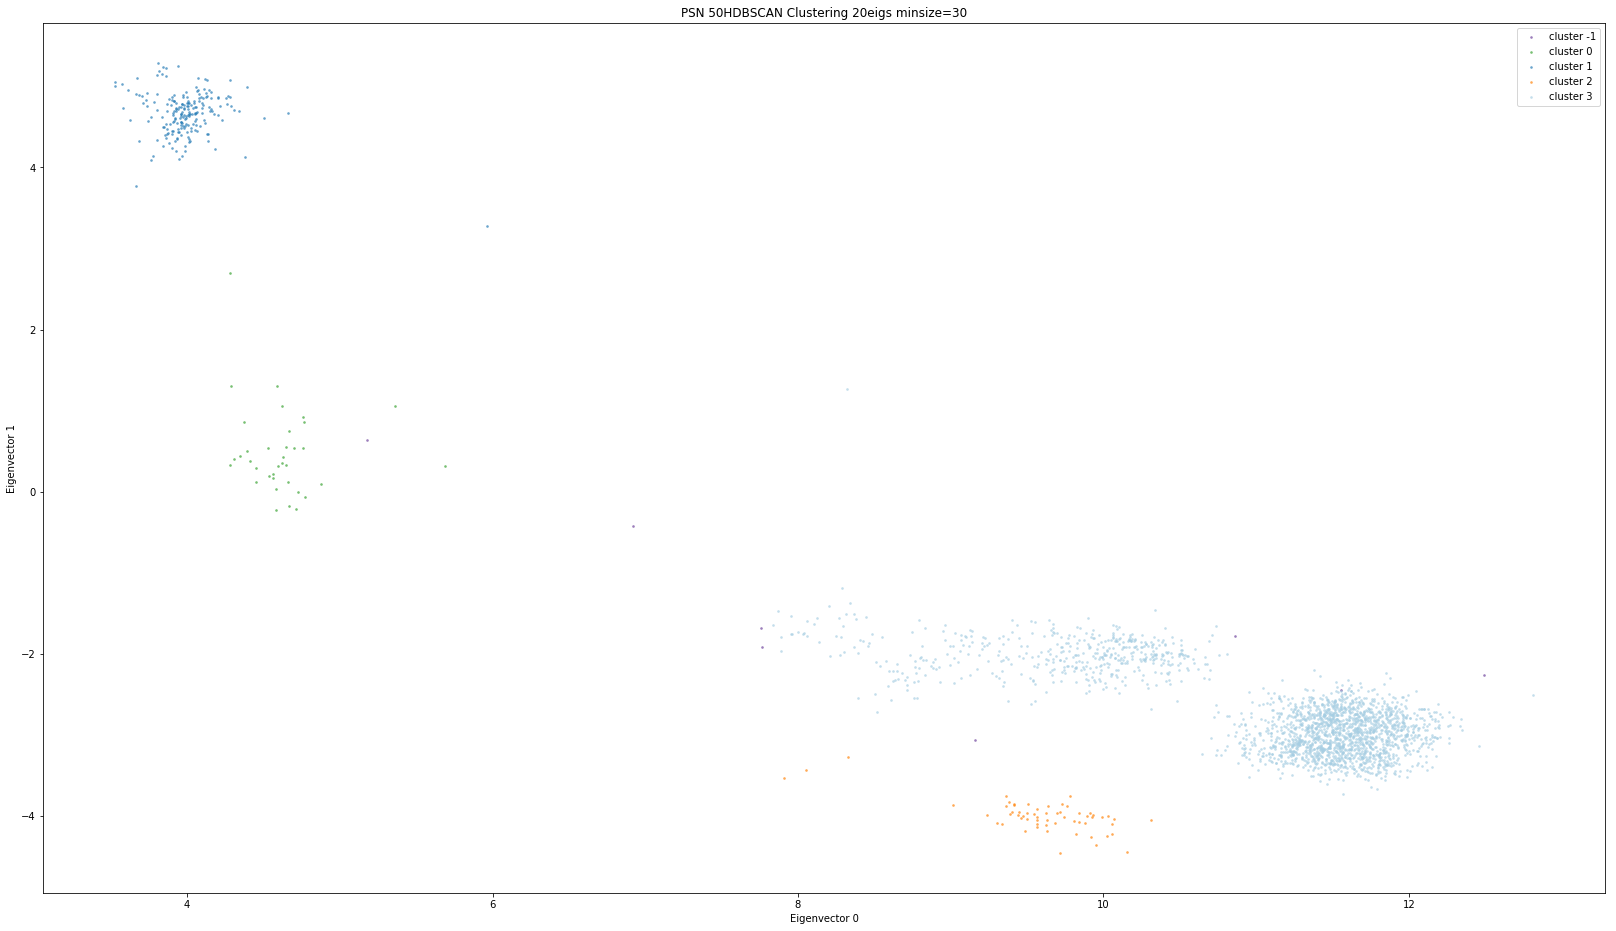

finished in total 0.776641845703125 seconds
started:  51
    clustering with min_cluster_size=30 min_samples=30.....(5462, 72) 5462
finished in 0.6866214275360107 seconds
    saving figure.....

C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


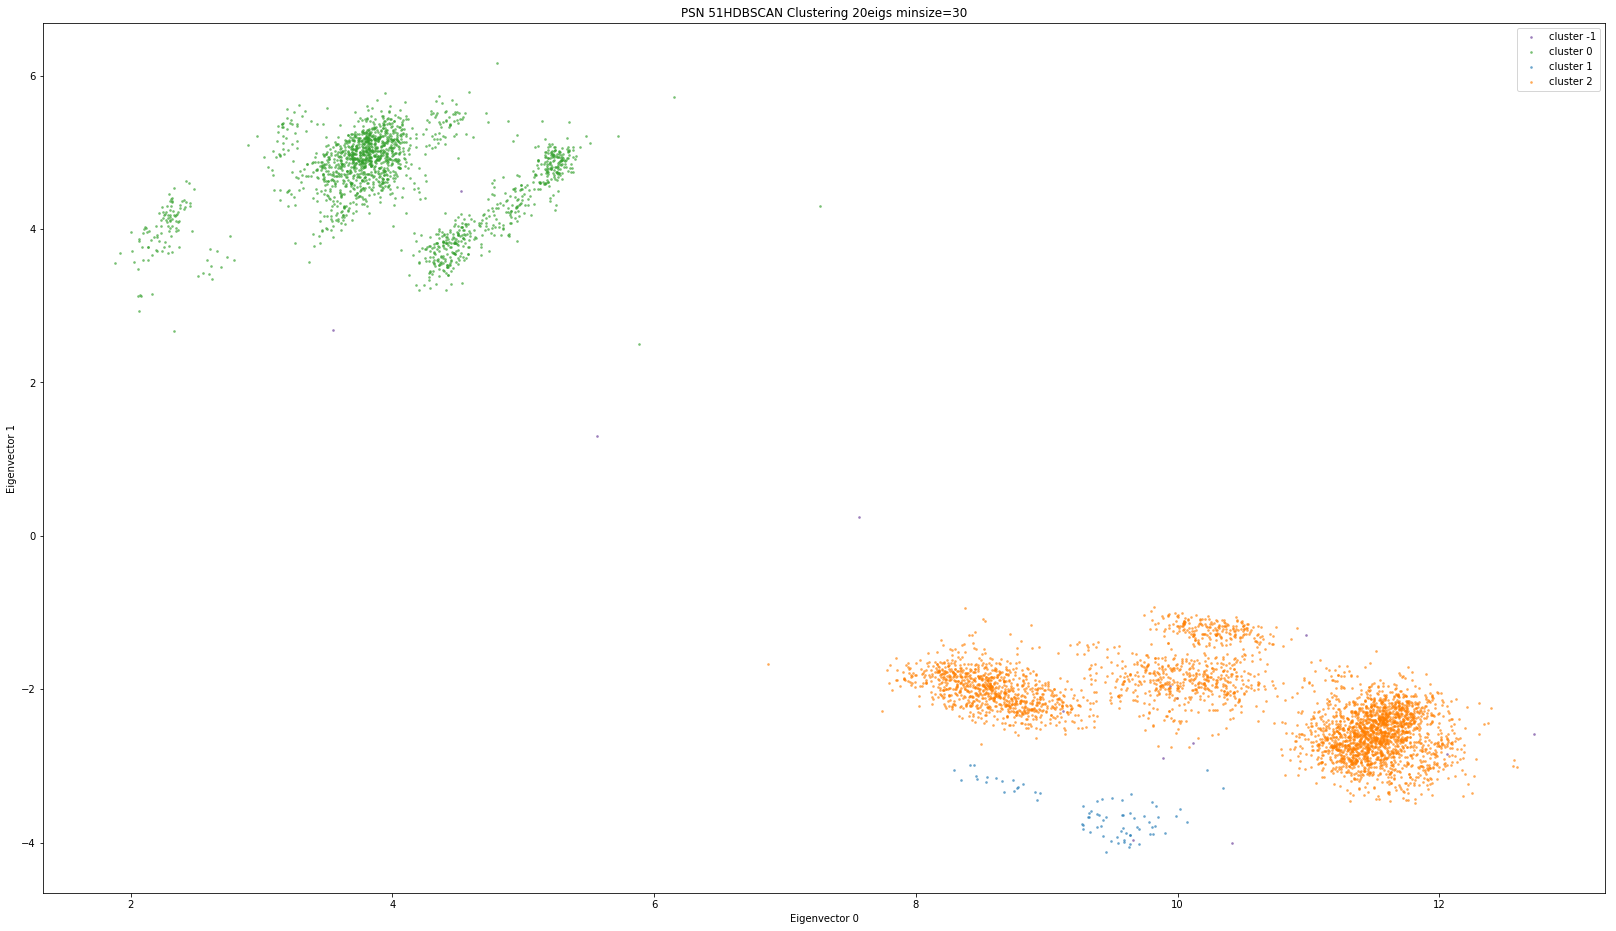

finished in total 1.1950037479400635 seconds


In [47]:
num_eigs_toclust = 20 ## 20 eigenvectors cover 90% variance

# current_directory = os.getcwd()
# final_directory = os.path.join(current_directory,r'Hdbscan Clustering mc lendiv70')
# if not os.path.isdir(final_directory):
#     os.mkdir(final_directory)

# for psn in sorted(rd_df['psn'].unique()):
# def clusterandplot(rd_df, psn, num_eigs_toclust):
# for psn in sorted(rd_df['psn'].unique()):
for psn in [50,51]:
    print('started: ',psn)
    nao = time.time()
    newdf = rd_df[rd_df['psn']==psn]
    min_clust_size = 30# int(len(newdf)/70.3)+1
#     hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_clust_size) ## 70.3 chosen arbitrarily
    print('    clustering with min_cluster_size={} min_samples={}.....'.format(min_clust_size,int(min_clust_size)),end="",flush=True)
#     cluster_results = cluster_eigs(reduced_df=rd_df, psn=psn, cols=list(range(num_eigs_toclust)), cluster_algo=hdbscan)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_clust_size, min_samples=int(min_clust_size))
    clusterer_results = clusterer.fit_predict(newdf[list(range(num_eigs_toclust))])
    print(newdf.shape, len(clusterer_results))
    print('finished in {} seconds'.format(time.time()-nao))
    newdf['cluster'] = clusterer_results
    figname = 'PSN '+str(psn)+'HDBSCAN Clustering 20eigs minsize='+str(min_clust_size)
    print('    saving figure.....',end="",flush=True)
    plot_clusters(newdf, x=0, y=1, colorpal = color_pal, save_fig=False, title = figname)
    print('finished in total {} seconds'.format(time.time()-nao))

In [48]:
metrics.f1_score(clusterer_results, model2_10min[model2_10min['psn']==51]['powerjump'].values,average='micro')

0.31709996338337604

started:  50
    clustering with min_cluster_size=210 min_samples=210.....(2516, 72) 2516
finished in 0.40612268447875977 seconds
    saving figure.....

C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


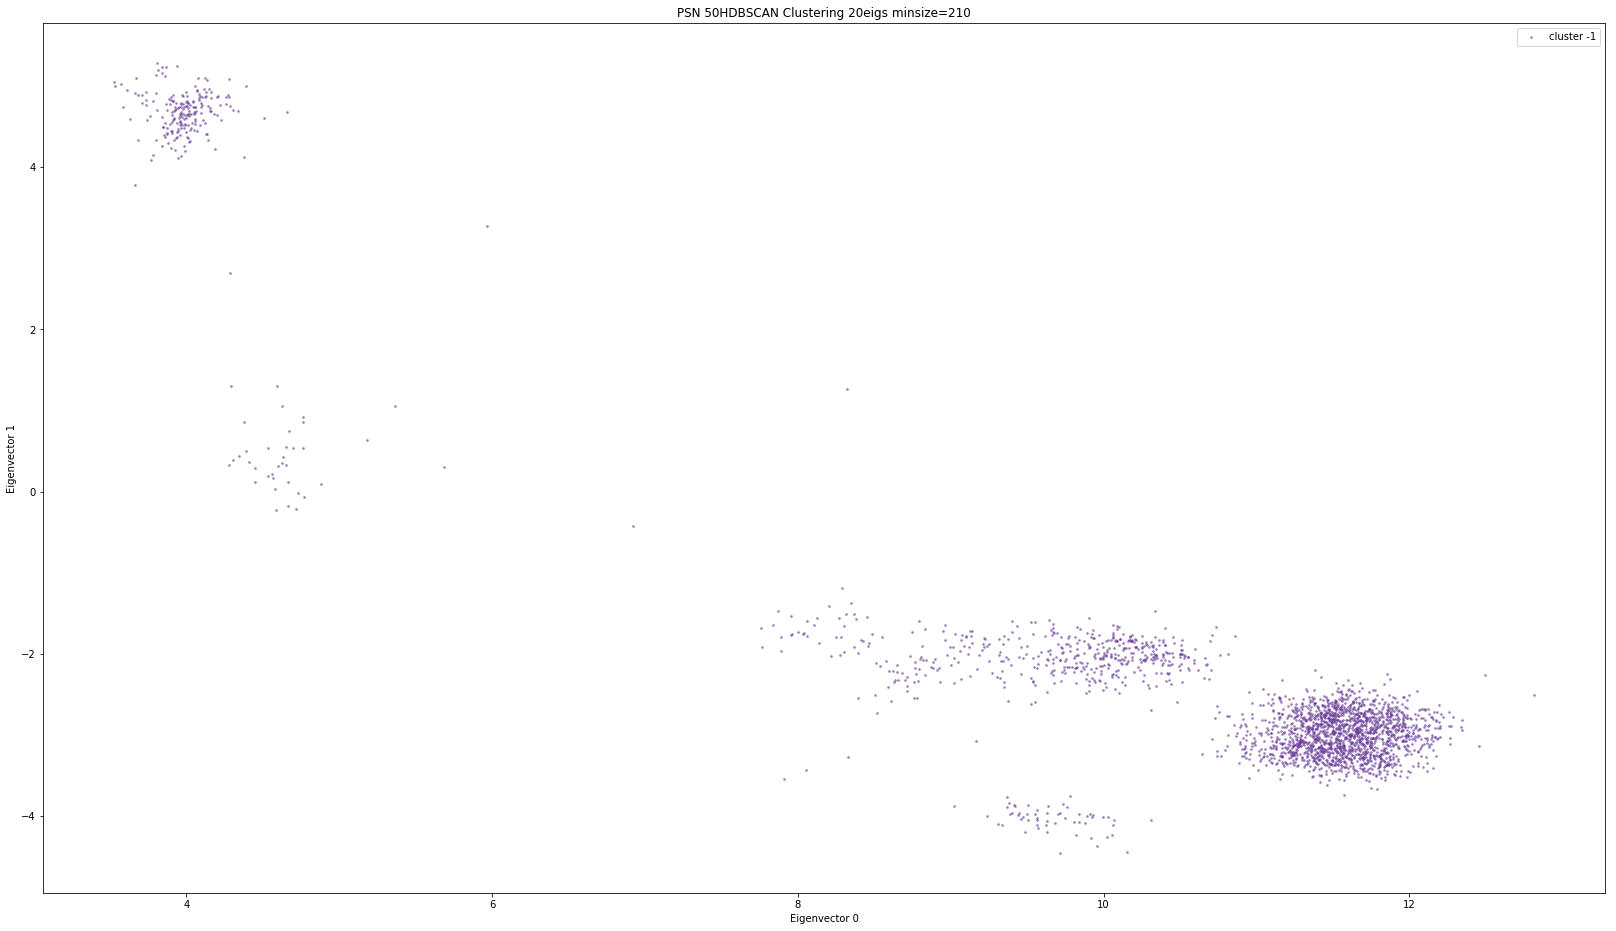

finished in total 0.8512089252471924 seconds
started:  51
    clustering with min_cluster_size=456 min_samples=456.....(5462, 72) 5462
finished in 1.4634125232696533 seconds
    saving figure.....

C:\Users\d59628\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


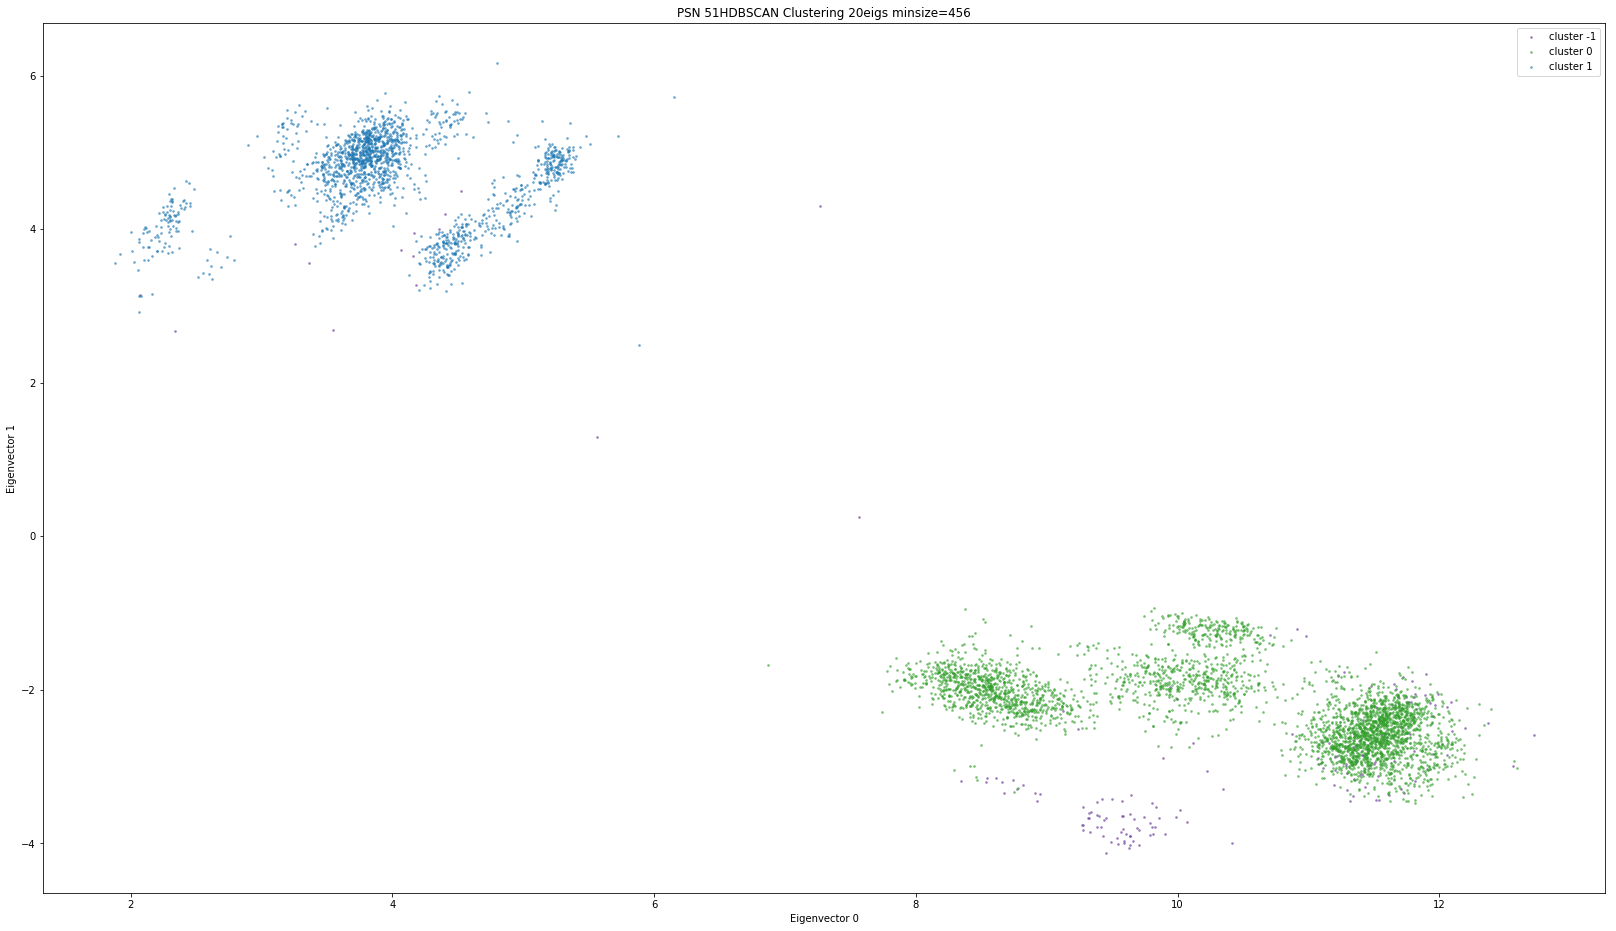

finished in total 1.9259862899780273 seconds


In [45]:
num_eigs_toclust = 20 ## 20 eigenvectors cover 90% variance

# current_directory = os.getcwd()
# final_directory = os.path.join(current_directory,r'Hdbscan Clustering mc lendiv70')
# if not os.path.isdir(final_directory):
#     os.mkdir(final_directory)

# for psn in sorted(rd_df['psn'].unique()):
# def clusterandplot(rd_df, psn, num_eigs_toclust):
# for psn in sorted(rd_df['psn'].unique()):
for psn in [50,51]:
    print('started: ',psn)
    nao = time.time()
    newdf = rd_df[rd_df['psn']==psn]
    min_clust_size =  int(len(newdf)/12)+1
#     hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_clust_size) ## 70.3 chosen arbitrarily
    print('    clustering with min_cluster_size={} min_samples={}.....'.format(min_clust_size,int(min_clust_size)),end="",flush=True)
#     cluster_results = cluster_eigs(reduced_df=rd_df, psn=psn, cols=list(range(num_eigs_toclust)), cluster_algo=hdbscan)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_clust_size, min_samples=int(min_clust_size*1.4)+1)
    clusterer_results = clusterer.fit_predict(newdf[list(range(num_eigs_toclust))])
    print(newdf.shape, len(clusterer_results))
    print('finished in {} seconds'.format(time.time()-nao))
    newdf['cluster'] = clusterer_results
    figname = 'PSN '+str(psn)+'HDBSCAN Clustering 20eigs minsize='+str(min_clust_size)
    print('    saving figure.....',end="",flush=True)
    plot_clusters(newdf, x=0, y=1, colorpal = color_pal, save_fig=False, title = figname)
    print('finished in total {} seconds'.format(time.time()-nao))

In [60]:
 model2_10min[(model2_10min['psn']==41)&(model2_10min['powerjump']==1)]

,timestamp,psn,id,lo_c_dp1,f_c_dp1,f_c_dp2,f_c_dp5,pe_c_dt1,g_c_dt1,g_c_dt2,lo_c_dt5,c_dt5_1,c_dt5_2,c_dt5_3,c_dt5_4,c_dt5_5,c_dt5_6,sc_c_pct_e1,pe_c_pos_e1,f_c_pos_e2,f_c_pos_e1,c_c_t5_1,c_c_t5_2,c_c_t5_3,t5_s1,pe_p1,f_cmd1,pe_t1,perf_pow,sum_eng_h,lo_p1,b_p1,g_t1,t5_6,g_t5,g_t4,v_d_1b,g_cur1,g_cur4,g_cur3,lo_t9,f_cmd2,lo_t6,t5_5,t5_2,t5_3,t5_1,ngp,nt5,pcd,v_acc1,sc_pct2,g_pow1,pe_for1,sc_pct1,pe_cmd1,pe_pos1,g_cur2,t1_1,sum_esn,t5_4,f_p2,t5_a,sum_eng_st,lo_dp1,v_d_3b,f_p7,f_p1,v_d_2b,lo_t5,g_t2,f_t1,sum_enr,g_t3,g_pct1,f_pos1,powerjump
1522950,2017-08-12 12:30:00.000003,41,616270,0.490864,0.136700,0.005676,0.281362,0.266667,0.024,0.098,0.529412,-0.099778,-0.093111,-0.037445,0.072222,0.154222,0.003889,0.010066,-0.131401,0.02110,0.042261,0.499890,0.435429,0.446123,0.304800,0.563141,0.966984,0.681818,0.189098,0.730567,0.904156,0.11995,0.921714,0.500668,0.5908,0.5924,0.177143,0.388058,0.393214,0.398437,0.947368,0.385133,1.067333,0.530735,0.481268,0.492402,0.479935,0.996689,1.0,0.241822,0.160000,0.958210,0.7561,0.288324,-0.0052,0.872549,0.892628,0.393237,0.4425,74.0,0.514335,0.690199,0.499891,159.0,0.423076,0.484,16.349506,0.688341,0.137143,0.891739,0.942857,0.7320,5592.716962,0.5948,0.19100,0.964342,1
1522952,2017-08-12 12:50:00.000002,41,616272,0.482308,0.141241,0.011353,0.285311,0.266667,0.042,0.112,0.524706,-0.092389,-0.098056,-0.031389,0.075944,0.143611,0.002278,-0.018936,-0.131401,-0.00138,-0.022240,0.464575,0.414286,0.434508,0.290000,0.563141,0.943321,0.692121,0.140127,0.730567,0.915013,0.10950,0.921714,0.465031,0.5892,0.5892,0.171429,0.346250,0.352388,0.356563,0.942632,0.359289,1.061333,0.493298,0.444964,0.458298,0.446098,0.997793,1.0,0.237827,0.120000,0.959689,0.6733,0.239593,-0.0052,0.872549,0.892628,0.351719,0.4510,74.0,0.479764,0.690199,0.464575,159.0,0.419232,0.452,16.348087,0.688221,0.145714,0.886087,0.941714,0.7305,5592.779747,0.5936,0.25471,0.944711,1
1523065,2017-08-13 08:29:59.999996,41,616385,0.448630,0.122559,0.000000,0.290259,0.254444,0.050,0.112,0.527059,-0.102722,-0.055389,0.015944,0.065278,0.099944,-0.023056,-0.022268,-0.083351,0.01226,0.043080,0.367201,0.347429,0.340474,0.243200,0.566507,0.941395,0.604242,0.049490,0.731200,0.999535,0.11735,0.881143,0.362590,0.5484,0.5464,0.185714,0.240558,0.246741,0.243984,0.906316,0.330895,1.011333,0.387190,0.356123,0.370390,0.346657,1.001204,1.0,0.233515,0.080000,0.963017,0.2526,0.212791,-0.0052,0.872549,0.891667,0.243739,0.3840,74.0,0.380257,0.690789,0.367201,160.0,0.419232,0.416,16.367950,0.689177,0.120000,0.854348,0.898857,0.7285,5597.771646,0.5508,0.22347,0.938702,1
1524314,2017-08-22 09:10:00.000004,41,617635,0.444171,0.154858,-0.017021,0.271420,0.284445,0.110,0.194,0.614118,-0.162111,-0.058444,-0.021778,0.062556,0.171222,0.008556,0.025665,-0.019249,-0.02966,-0.012640,0.515422,0.571429,0.473921,0.400000,0.564263,0.961149,0.626061,0.211915,0.738167,0.921216,0.11595,0.840571,0.517133,0.5660,0.5736,0.228571,0.415067,0.420781,0.422701,0.860000,0.395181,0.944000,0.549666,0.503733,0.511066,0.482999,1.000000,1.0,0.251582,0.173333,0.961168,0.8490,0.263146,-0.0052,0.872549,0.890385,0.419487,0.3885,74.0,0.527933,0.690199,0.515422,162.0,0.460256,0.372,16.343832,0.688341,0.088571,0.842609,0.864571,0.7330,5654.640000,0.5776,0.19849,0.961939,1
1524319,2017-08-22 09:59:59.999996,41,617640,0.443696,0.169543,-0.005707,0.294073,0.256667,0.122,0.182,0.484706,-0.079222,-0.045222,-0.011889,0.095111,0.040444,0.000778,0.027868,-0.116301,0.00894,0.157620,0.807127,0.298857,0.272943,0.209200,0.562019,0.104002,0.612121,0.454652,0.738200,0.914237,0.09125,0.836000,0.807282,0.5344,0.5380,0.225714,0.861696,0.868661,0.871295,0.853684,0.524598,0.934667,0.815215,0.798082,0.804749,0.791282,1.000803,1.0,0.227886,0.261333,0.961909,0.8337,0.157563,-0.0052,0.521538,0.534295,0.867187,0.3895,74.0,0.826149,0.689018,0.807127,162.0,0.466668,0.336,16.311199,0.686847,0.074286,0.788696,0.853143,0.7365,5654.849114,0.5412,0.13668,0.094151,1
1524387,2017-08-22 21:19:59.999998,41,617708,0.425422,0.204279,-0.011345,

In [46]:
metrics.f1_score(clusterer_results, model2_10min[model2_10min['psn']==51]['powerjump'].values,average='micro')

0.6482973269864518